In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import drone_sar

In [4]:
from drone_sar.ipsar_dataset import IPSARDataset
import matplotlib.pyplot as plt

In [5]:
DS_ROOT = "/Users/iz/Downloads/heridal/"

In [6]:
# !ls {DS_ROOT}

In [11]:
train_data = IPSARDataset("/Users/iz/Downloads/heridal/trainImages")
test_data = IPSARDataset("/Users/iz/Downloads/heridal/testImages")

In [16]:
item = test_data[0]

In [19]:
item.keys()

dict_keys(['pixel_values', 'boxes', 'class_labels'])

In [20]:
item['pixel_values'].shape

torch.Size([3000, 4000, 3])

In [21]:
item["boxes"].shape

torch.Size([2, 4])

In [23]:
item["class_labels"].shape

torch.Size([2])

In [44]:
X.shape

(3000, 4000, 3)

In [45]:
data = train_data
shapes = [X.shape for X, y in data]
boxes = [y["boxes"].numpy() for X, y in data]

In [46]:
set(shapes)

{(3000, 4000, 3)}

[]

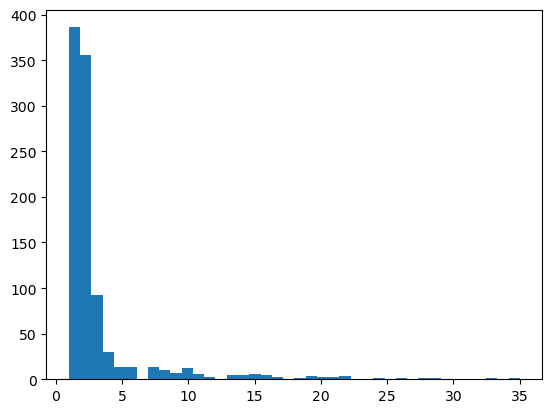

In [50]:
plt.hist([len(b) for b in boxes], bins=40)
plt.plot()

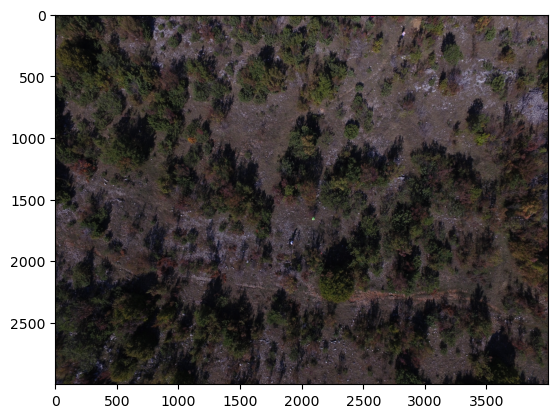

In [31]:
plt.imshow(X)